In [1]:
!pip install -q transformers
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.4/520.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
#from bertviz import head_view, model_view

from utils.data_preparation import get_emotion_dataset, naive_bayes_preprocessing, bert_preprocessing
from models.naive_bayes import NaiveBayes
from models.bert import Bert


In [3]:
emotion_labels = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']

In [4]:
SEED = 1
torch.manual_seed(SEED)
np.random.seed(SEED)

# Naive Bayes

## Hyperparameter search

See ``main.py`` for details of the Naive Bayes parameter search

In [5]:
with open('out/nb_grid_search_results.pkl', 'rb') as handle:
    nb_grid_search_results = pickle.load(handle)
print(nb_grid_search_results.head())

   alpha_prior  alpha_likelihood  use_bigrams  remove_stopwords  val_accuracy
0       100000               0.2         True              True        0.8350
1        10000               0.2         True              True        0.8320
2         1000               0.2         True              True        0.8285
3        10000               0.5        False              True        0.8280
4       100000               1.0        False              True        0.8270


## Test performance

Best Naive Bayes params from the grid search:
alpha_prior         100000
alpha_likelihood       0.2
use_bigrams           True
remove_stopwords      True
val_accuracy         0.835
Name: 0, dtype: object
-------- Naive Bayes results on test set ------
              precision    recall  f1-score   support

           0     0.8367    0.9174    0.8752       581
           1     0.8560    0.8978    0.8764       695
           2     0.7338    0.6415    0.6846       159
           3     0.8683    0.7673    0.8147       275
           4     0.8257    0.8036    0.8145       224
           5     0.7941    0.4091    0.5400        66

    accuracy                         0.8385      2000
   macro avg     0.8191    0.7394    0.7676      2000
weighted avg     0.8369    0.8385    0.8343      2000

Micro f1 score:  0.8385


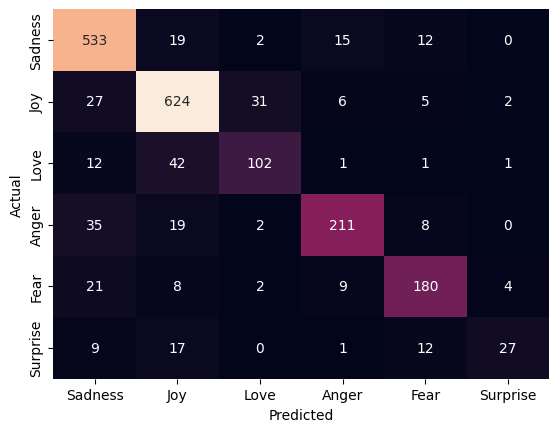

In [7]:
# take params from best model
best_params = nb_grid_search_results.iloc[0]
print(f"Best Naive Bayes params from the grid search:\n{best_params}")

processed_data, vectorizer = naive_bayes_preprocessing(
    remove_stopwords=best_params['remove_stopwords'],
    use_bigrams=best_params['use_bigrams']
)
X_train, y_train = processed_data['train']
X_test, y_test = processed_data['test']

nb = NaiveBayes()
nb.fit(X_train, y_train, alpha_prior=best_params['alpha_prior'],
                         alpha_likelihood=best_params['alpha_likelihood'])
y_pred = nb.predict(X_test)

print('-------- Naive Bayes results on test set ------')
print(classification_report(y_test, y_pred, digits=4))
print('Micro f1 score: ', f1_score(y_test, y_pred, average='micro'))
ax= plt.subplot()
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.xaxis.set_ticklabels(emotion_labels); ax.yaxis.set_ticklabels(emotion_labels);
plt.savefig('./out/figures/nb_model_confmatrix.png', dpi=400)
plt.show()

## Feature Analysis

In [ ]:
feature_names = vectorizer.get_feature_names_out()
class_log_probabilities = nb.feature_log_prob_
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

for i, class_probabilities in enumerate(class_log_probabilities):
    # sort features by their log prob
    sorted_features = np.argsort(class_probabilities)

    # get the top n feature
    top_features = sorted_features[-5:][::-1]
    top_scores = class_probabilities[top_features]
    top_scores = np.exp(top_scores)
    top_feature_names = feature_names[top_features]

    print(f"Class {i} ({class_names[i]}):", end=' ')
    for feature_name, score in zip(top_feature_names, top_scores):
        print(f"'{feature_name}' ({score:.4f})", end=' ')
    print()


Class 0 (sadness): 'feel' (0.0362) 'feeling' (0.0167) 'like' (0.0095) 'im' (0.0075) 'feel like' (0.0057) 
Class 1 (joy): 'feel' (0.0368) 'feeling' (0.0144) 'like' (0.0094) 'im' (0.0075) 'feel like' (0.0058) 
Class 2 (love): 'feel' (0.0221) 'feeling' (0.0090) 'like' (0.0073) 'im' (0.0046) 'feel like' (0.0044) 
Class 3 (anger): 'feel' (0.0270) 'feeling' (0.0134) 'like' (0.0071) 'im' (0.0063) 'feel like' (0.0047) 
Class 4 (fear): 'feel' (0.0241) 'feeling' (0.0148) 'im' (0.0064) 'like' (0.0051) 'just' (0.0034) 
Class 5 (surprise): 'feel' (0.0121) 'feeling' (0.0071) 'im' (0.0031) 'like' (0.0031) 'amazed' (0.0023) 


- the relatively small differences in probabilities between the same words across classes suggest that there is a significant overlap in how these words are used to express different emotions
- the presence of certain words with unique associations to an emotion (like 'amazed' for surprise) could be more discriminative and valuable for the classification task

# BERT (3 models)

## Hyperparameter search

See ``main.py`` for details of the Bert model hyperparameter search

In [8]:
with open('out/bert_grid_search_results.pkl', 'rb') as handle:
    nb_grid_search_results = pickle.load(handle)
print(nb_grid_search_results.head())

   epochs  batch_size       lr  weight_decay  fine_tune_last_layers  \
0       3         128  0.00001         0.010                  False   
1       3          32  0.00001         0.001                   True   
2       3         128  0.00002         0.001                   True   
3       3          64  0.00001         0.001                   True   
4       3          32  0.00003         0.001                   True   

   val_accuracy  
0         0.943  
1         0.942  
2         0.942  
3         0.942  
4         0.942  


## Test Performance (3 models)

In [83]:
bert_processed_data, tokenizer = bert_preprocessing()
input_ids_train, attention_mask_train, y_train = bert_processed_data['train']
input_ids_val, attention_mask_val, y_val = bert_processed_data['validation']
input_ids_test, attention_mask_test, y_test = bert_processed_data['test']

train_dataset = TensorDataset(input_ids_train, attention_mask_train, y_train)
val_dataset = TensorDataset(input_ids_val, attention_mask_val, y_val)
test_dataset = TensorDataset(input_ids_test, attention_mask_test, y_test)

### Bert Out of the Box Test Performance

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

              precision    recall  f1-score   support

           0     0.9689    0.9639    0.9664       581
           1     0.9415    0.9496    0.9456       695
           2     0.8400    0.7925    0.8155       159
           3     0.9398    0.9091    0.9242       275
           4     0.8636    0.9330    0.8970       224
           5     0.7619    0.7273    0.7442        66

    accuracy                         0.9265      2000
   macro avg     0.8860    0.8792    0.8821      2000
weighted avg     0.9265    0.9265    0.9262      2000

Micro f1 score:  0.9265


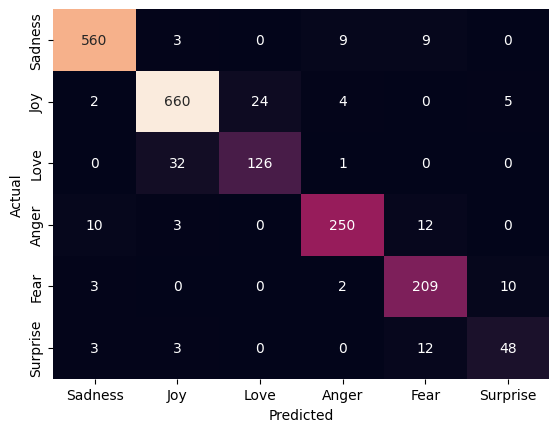

In [10]:
# Bert Out of the Box model. Use same batch size as next two models.
batch_size = 128

test_loader = DataLoader(test_dataset, batch_size=batch_size)

bert = Bert()
y_pred = bert.predict(test_loader)

print(classification_report(y_test, y_pred, digits=4))

ax = plt.subplot()
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.xaxis.set_ticklabels(emotion_labels); ax.yaxis.set_ticklabels(emotion_labels);
#plt.savefig('./out/figures/bert_base_model_confmatrix.png', dpi=400)
plt.show()

### Bert Fine tuned (all layers) test performance

              precision    recall  f1-score   support

           0     0.9675    0.9742    0.9708       581
           1     0.9592    0.9468    0.9529       695
           2     0.8221    0.8428    0.8323       159
           3     0.9296    0.9127    0.9211       275
           4     0.8798    0.9152    0.8972       224
           5     0.7937    0.7576    0.7752        66

    accuracy                         0.9320      2000
   macro avg     0.8920    0.8915    0.8916      2000
weighted avg     0.9323    0.9320    0.9321      2000



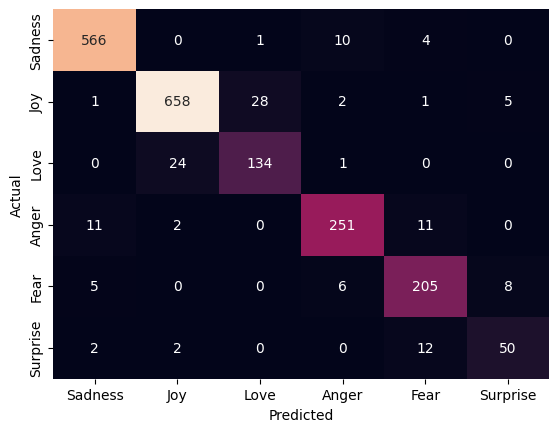

In [84]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_eval = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Load best model from the hyperparameter grid search
bert_fta = Bert()
bert_fta.model.load_state_dict(torch.load('out/params/bert_fta_params.bin'))
y_pred = bert_fta.predict(test_loader)

print(classification_report(y_test, y_pred, digits=4))

ax = plt.subplot()
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.xaxis.set_ticklabels(emotion_labels); ax.yaxis.set_ticklabels(emotion_labels);
#plt.savefig('./out/figures/all_layers_confmatrix.png', dpi=400)
plt.show()

### Bert Fine tuned (last layer only) test performance

              precision    recall  f1-score   support

           0     0.9689    0.9639    0.9664       581
           1     0.9415    0.9496    0.9456       695
           2     0.8400    0.7925    0.8155       159
           3     0.9398    0.9091    0.9242       275
           4     0.8636    0.9330    0.8970       224
           5     0.7619    0.7273    0.7442        66

    accuracy                         0.9265      2000
   macro avg     0.8860    0.8792    0.8821      2000
weighted avg     0.9265    0.9265    0.9262      2000



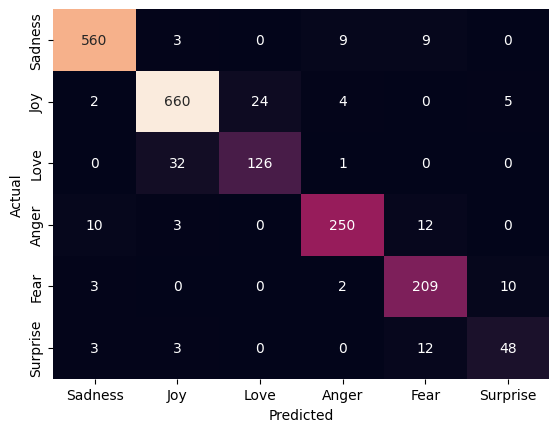

In [85]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Load best model from the hyperparameter grid search
bert_ftl = Bert()
bert_fta.model.load_state_dict(torch.load('out/params/bert_fta_params.bin'))
y_pred = bert_ftl.predict(test_loader)

print(classification_report(y_test, y_pred, digits=4))

ax = plt.subplot()
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.xaxis.set_ticklabels(emotion_labels); ax.yaxis.set_ticklabels(emotion_labels);
#plt.savefig('./out/figures/final_layers_confmatrix.png', dpi=400)
plt.show()

## Attention Matrix Analysis (Bert OOB model only)

First, we consider how attention varies in the Bert OOB model accross different samples.

In [86]:
bert_processed_data, tokenizer = bert_preprocessing()
input_ids_train, attention_mask_train, y_train = bert_processed_data['train']
input_ids_val, attention_mask_val, y_val = bert_processed_data['validation']
input_ids_test, attention_mask_test, y_test = bert_processed_data['test']

In [87]:
size = 256  # number of samples to test
y_test = y_test[:size]
input_ids_test = input_ids_test[:size]
attention_mask_test = attention_mask_test[:size]
test_dataset = TensorDataset(input_ids_test, attention_mask_test, y_test)

bert_oob = Bert()
test_loader = DataLoader(test_dataset, batch_size=size)
y_pred, attentions = bert_oob.predict(test_loader, return_attentions=True)

In [88]:
def get_pos_neg_sample(y_true, y_pred, class_idx):
  """Find examples of positive and negative samples for each class"""

  correctly_classified_index = None
  misclassified_index = None

  for i, (pred, actual) in enumerate(zip(y_pred, y_true)):
    if pred == actual == class_idx:
        correctly_classified_index = i
        if misclassified_index is not None:
          break
    elif pred != actual and actual == class_idx:
      misclassified_index = i
      if correctly_classified_index is not None:
        break

  return [correctly_classified_index, misclassified_index]


In [90]:
# Get positive and negative samples for each class
attention_samples = {emotion_labels[i]: get_pos_neg_sample(y_test, y_pred, i) for i in range(len(emotion_labels))}
attention_samples

{'Sadness': [145, 150],
 'Joy': [227, 232],
 'Love': [71, 74],
 'Anger': [33, 40],
 'Fear': [103, 108],
 'Surprise': [69, 72]}

In [89]:
# Pick a specific transformer layer/head
layer = 3
head = 7

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Bert OOB Attention Matrix at head 7, layer 3 for correctly-labelled (+) and incorrectly labelled (-) samples:


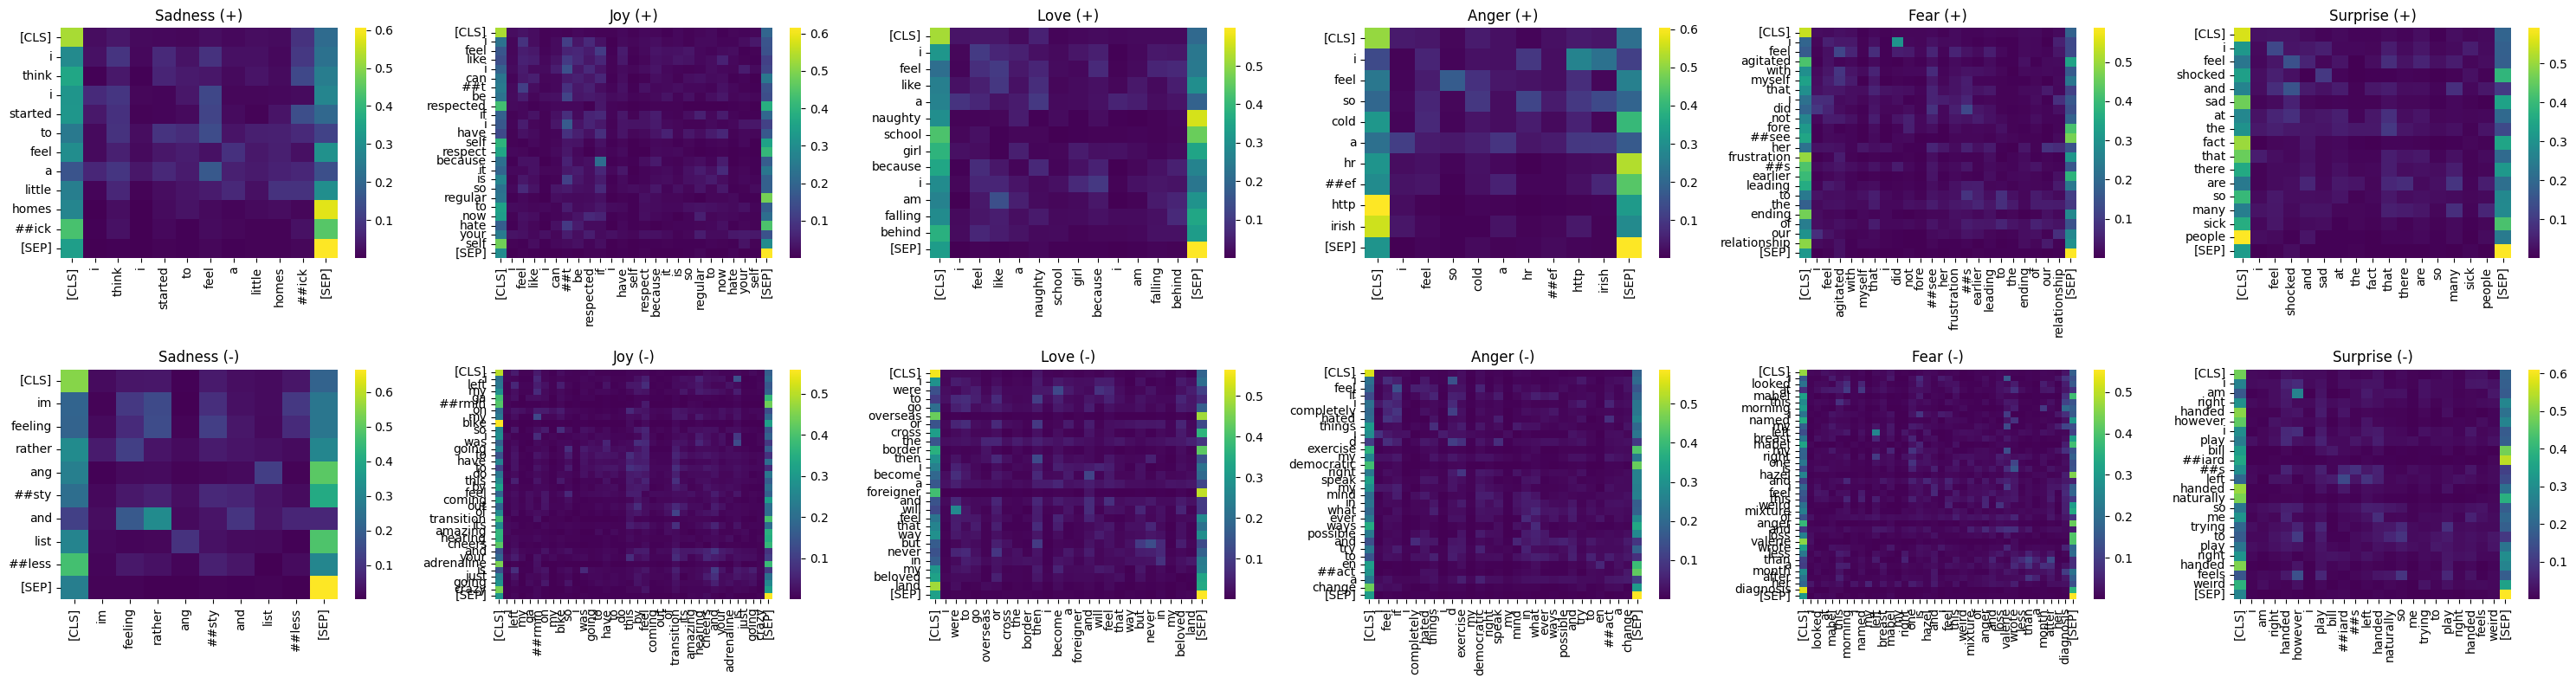

In [94]:
from itertools import compress

fig, ax = plt.subplots(2, 6, figsize=(30, 8))

# Plot attention matrices for each sample
for i, emotion in enumerate(list(attention_samples.keys())):
  for j in range(2):
    sample_idx = attention_samples[emotion][j]

    selected_attention = attentions[layer][:, head, :, :].squeeze().detach().cpu().numpy()

    non_padding_mask = input_ids_test[sample_idx] != 0 # filter out padding tokens
    blah = input_ids_test[sample_idx].detach().tolist()
    token_list = tokenizer.convert_ids_to_tokens(blah)
    tokens = list(compress(token_list, non_padding_mask))
    filtered_attention = selected_attention[sample_idx][non_padding_mask][:, non_padding_mask]

    sns.heatmap(filtered_attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis', ax=ax[j, i])

    if j == 0:
      plot_title = f'{emotion} (+)'
    else:
      plot_title = f'{emotion} (-)'
    ax[j,i].set_title(plot_title)

print(f'Bert OOB Attention Matrix at head {head}, layer {layer} for correctly-labelled (+) and incorrectly labelled (-) samples:')
plt.tight_layout()
plt.show()


## Attention Matrix Analysis (Comparison of all models)

Next, for a fixed sample, we see what effect the fine tuning has on the attention matrices.

In [41]:
bert_oob = Bert()
bert_fta = Bert()
bert_fta.model.load_state_dict(torch.load('out/params/bert_fta_params.bin'))
bert_ftl = Bert()
bert_ftl.model.load_state_dict(torch.load('out/params/bert_ftl_params.bin'))

<All keys matched successfully>

In [95]:
test_loader = DataLoader(test_dataset, batch_size=size)
y_pred_oob, attentions_oob = bert_oob.predict(test_loader, return_attentions=True)
y_pred_fta, attentions_fta = bert_fta.predict(test_loader, return_attentions=True)
y_pred_ftl, attentions_ftl = bert_ftl.predict(test_loader, return_attentions=True)


In [96]:
models = {'Bert OOB': {'preds': y_pred_oob, 'attentions': attentions_oob},
          'Bert FTA': {'preds': y_pred_fta, 'attentions': attentions_fta},
          'Bert FTL': {'preds': y_pred_ftl, 'attentions': attentions_ftl}
          }

In [97]:
layer = 9
head = 4
sample_idx = 108

Attention matrices at layer 9, head 4 for sample 108:


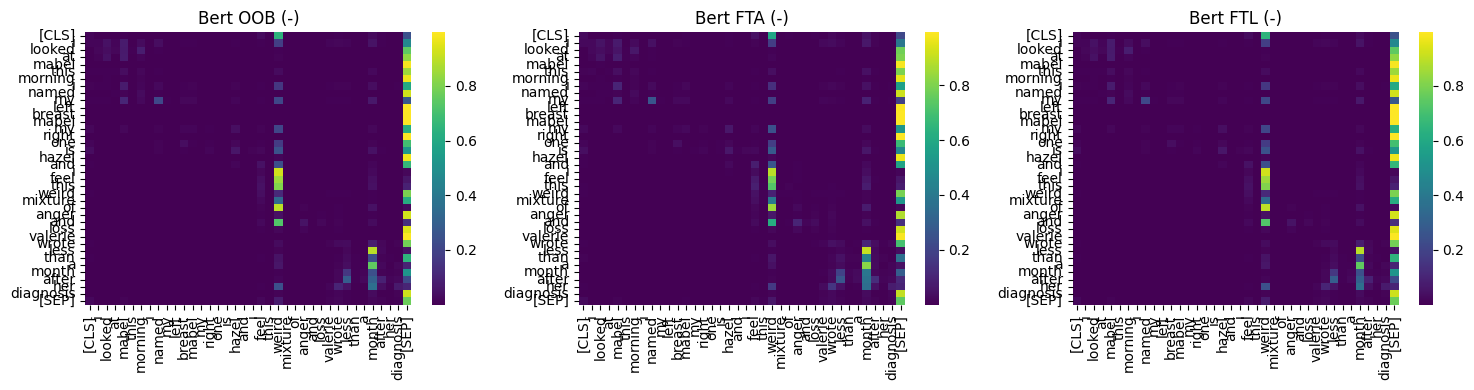

In [99]:
from itertools import compress

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for j, model_name in enumerate(list(models.keys())):

  selected_attention = models[model_name]['attentions'][layer][:, head, :, :].squeeze().detach().cpu().numpy()

  non_padding_mask = input_ids_test[sample_idx] != 0 # filter out padding tokens
  blah = input_ids_test[sample_idx].detach().tolist()
  token_list = tokenizer.convert_ids_to_tokens(blah)
  tokens = list(compress(token_list, non_padding_mask))
  filtered_attention = selected_attention[sample_idx][non_padding_mask][:, non_padding_mask]

  sns.heatmap(filtered_attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis', ax=ax[j])

  if models[model_name]['preds'][sample_idx] == y_test[sample_idx]:
    plot_title = f'{model_name} (+)'
  else:
    plot_title = f'{model_name} (-)'

  ax[j].set_title(plot_title)

print(f'Attention matrices at layer {layer}, head {head} for sample {sample_idx}:')
plt.tight_layout()
plt.show()
